# Raisin prediction using Bayesian Networks
FAIKR module 3 project, done by Michele Calvanese, Samuele Marino  

## Introduction

The goal of this exploratory study was to develop and assess a prediction model which can potentially be used as a biomarker of breast cancer, based on anthropometric data and parameters which can be gathered in routine blood analysis.

For each of the 116 participants several clinical features were observed or measured, including age, BMI, Glucose, Insulin, HOMA, Leptin, Adiponectin, Resistin and MCP-1


Attribute Information:


1. Age: The age of the participant
2. BMI: is a measure of body size. It combines a person’s weight with their height.
3. Glucose: is a simple sugar which is an important energy source in living organisms
4. Insulin: is a hormone made in your pancreas, a gland located behind your stomach.
5. HOMA: is a method for assessing β-cell function and insulin resistance (IR) from basal (fasting) glucose and insulin or C-peptide concentrations.
6. Leptin: is a hormone your body releases that helps it maintain your normal weight on a long-term basis.
7. Adiponectin: is a protein hormone that is produced by fat cells.
8. Resistin: is a cysteine-rich hormone secreted from white adipocytes.
9. MCP-1: is one of the key chemokines that regulate migration and infiltration of monocytes/macrophages.


Dataset [link](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Coimbra).

In [1686]:
import pandas as pd
import numpy as np
import pgmpy
import networkx as nx
import pylab as plt
from pgmpy.models import BayesianNetwork, BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.estimators import HillClimbSearch, K2Score, BicScore, BDeuScore, MaximumLikelihoodEstimator
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout

## Data cleaning and preparation

All attributes were used for making the Bayesian Network model. Before creating the model, all the attributes need to be discretized, as the pgmpy library only works with discrete variables.

In [1687]:
path = "./Dataset/dataR2.xlsx"
data = pd.read_excel(path)
data.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1


In [1688]:
data.describe()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,57.301724,27.582111,97.793103,10.012086,2.694988,26.615080,10.180874,14.725966,534.647000,1.551724
std,16.112766,5.020136,22.525162,10.067768,3.642043,19.183294,6.843341,12.390646,345.912663,0.499475
min,24.000000,18.370000,60.000000,2.432000,0.467409,4.311000,1.656020,3.210000,45.843000,1.000000
25%,45.000000,22.973205,85.750000,4.359250,0.917966,12.313675,5.474283,6.881763,269.978250,1.000000
50%,56.000000,27.662416,92.000000,5.924500,1.380939,20.271000,8.352692,10.827740,471.322500,2.000000
75%,71.000000,31.241442,102.000000,11.189250,2.857787,37.378300,11.815970,17.755207,700.085000,2.000000
max,89.000000,38.578759,201.000000,58.460000,25.050342,90.280000,38.040000,82.100000,1698.440000,2.000000


In [1689]:
data.shape

(116, 10)

Before modifying the variables, dataset is checked for the presence of N/A values.

In [1690]:
data.isnull().sum()

Age               0
BMI               0
Glucose           0
Insulin           0
HOMA              0
Leptin            0
Adiponectin       0
Resistin          0
MCP.1             0
Classification    0
dtype: int64

So there is no N/A values

### Variable discretization

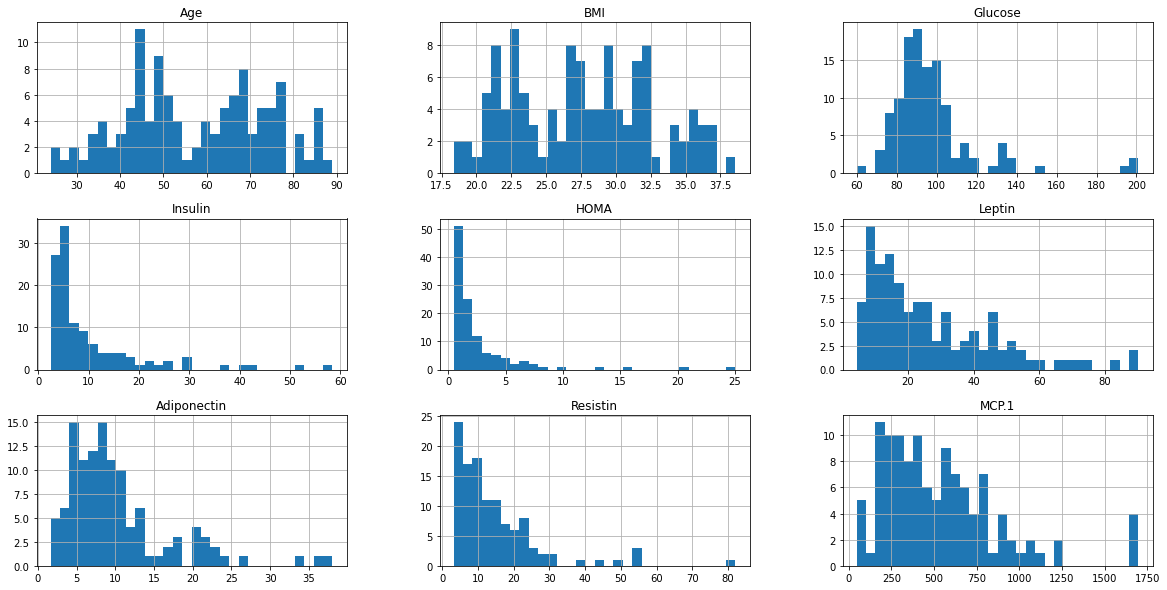

In [1691]:
data.drop('Classification', axis=1).hist(bins=30, figsize=(20, 10));

#### Age

In [1692]:
min = data['Age'].min()
max = data['Age'].max()


# migliore
data['Age'] = pd.cut(x=data['Age'],
                         bins=[min-1, 55, 80, max],
                         labels=["24-54", "55-79", "80+"])

# data['Age'] = pd.cut(x=data['Age'],
#                          bins=[min-1, 40, 55, 80, max],
#                          labels=["24-39", "39-54", "55-79", "80+"])


# data['Age'] = pd.cut(x=data['Age'],
#                      bins=[min-1, 60, max],
#                      labels=["<60", "60+"])



#### BMI

In [1693]:
min = data['BMI'].min()
max = data['BMI'].max()

data['BMI'] = pd.cut(x=data['BMI'],
                     bins=[min-1, 25, 33, max],
                     labels=["low", "medium", "high"])


#### Glucose

In [1694]:
min = data['Glucose'].min()
max = data['Glucose'].max()

data['Glucose'] = pd.cut(x=data['Glucose'],
                        bins=[min-1, 70, 120, max],
                        labels=["low", "medium", "high"])


#### Insulin

In [1695]:
min = data['Insulin'].min()
max = data['Insulin'].max()

# data['Insulin'] = pd.cut(x=data['Insulin'],
#                          bins=[min-1, 8, 30, max],
#                          labels=["low", "medium", "high"])

data['Insulin'] = pd.cut(x=data['Insulin'],
                         bins=[min-1, 20, max],
                         labels=["low", "high"])



#### HOMA

In [1696]:
min = data['HOMA'].min()
max = data['HOMA'].max()

data['HOMA'] = pd.cut(x=data['HOMA'],
                         bins=[min-1, 5, max],
                         labels=["low", "high"])


#### Leptin

In [1697]:
min = data['Leptin'].min()
max = data['Leptin'].max()

data['Leptin'] = pd.cut(x=data['Leptin'],
                         bins=[min-1, 20, 40, 60, max],
                        labels=["low", "medium", "high", "very high"])


#### Adiponectin

In [1698]:
min = data['Adiponectin'].min()
max = data['Adiponectin'].max()

data['Adiponectin'] = pd.cut(x=data['Adiponectin'],
                         bins=[min-1, 15, 30, max],
                         labels=["low", "medium", "high"])


#### Resistin

In [1699]:
min = data['Resistin'].min()
max = data['Resistin'].max()

data['Resistin'] = pd.cut(x=data['Resistin'],
                         bins=[min-1, 29, max],
                         labels=["low", "high"])


#### MCP.1

In [1700]:
min = data['MCP.1'].min()
max = data['MCP.1'].max()

data['MCP.1'] = pd.cut(x=data['MCP.1'],
                         bins=[min-1, 500, 800, 1500, max],
                         labels=["low", "medium", "high", "very high"])

In [1701]:
data.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,24-54,low,low,low,low,low,low,low,low,1
1,80+,low,medium,low,low,low,low,low,low,1
2,80+,low,medium,low,low,low,medium,low,medium,1
3,55-79,low,medium,low,low,low,low,low,high,1
4,80+,low,medium,low,low,low,low,low,medium,1


##  Bayesian Network

### Learning the structure of the network and analyzing it 

One option for defining the structure of the network would be to manually add the nodes and connections between them. Knowing the connections between nodes requires having a sufficient knowledge about the field of application in order to be able to define conditional independence assertions. 

Luckily, pgmpy library offers many ways for learning a structure for discrete, fully observed networks. Given a set of data samples, the algorithm estimates a directed acyclic graph that captures dependencies between the variables. We will use Score-based structure estimation that learns the model as an optimization task, and which lets the programmer choose a search strategy and a scoring function which will be used.

Some of the available search strategies are:

- Exaustive search
- Hill Climb search

The search space is super-exponential regarding the number of variables, which is the reason why Exaustive search wasn't chosen for this particular project. However, for very small number of nodes it is guaranteed to find the best-scoring graph. When networks are bigger it is better to use Hill Climb search that implements a greedy local search starting usually from a disconected graph. In every iteration it makes one change on egdes of the graph that maximally increases the score. 

In [1702]:
#learning the stucutre of the network
est = HillClimbSearch(data)
best_model = est.estimate(scoring_method=BDeuScore(data))

  0%|          | 15/1000000 [00:02<38:11:37,  7.27it/s]


In [1703]:
#the estimated model returns a DAG at a (local) score maximum
edges = list(best_model.edges())
model = BayesianNetwork(edges)
#nodes of the model
model.nodes

NodeView(('Age', 'HOMA', 'BMI', 'Leptin', 'Classification', 'Glucose', 'Insulin', 'MCP.1', 'Adiponectin', 'Resistin'))

In [1705]:
#edges of the model
model.edges

OutEdgeView([('Age', 'HOMA'), ('HOMA', 'Insulin'), ('HOMA', 'Glucose'), ('HOMA', 'MCP.1'), ('BMI', 'Leptin'), ('BMI', 'Age'), ('BMI', 'Classification'), ('Leptin', 'HOMA'), ('Glucose', 'Classification'), ('Insulin', 'Glucose'), ('MCP.1', 'Resistin'), ('Adiponectin', 'BMI'), ('Adiponectin', 'Insulin'), ('Resistin', 'Classification')])

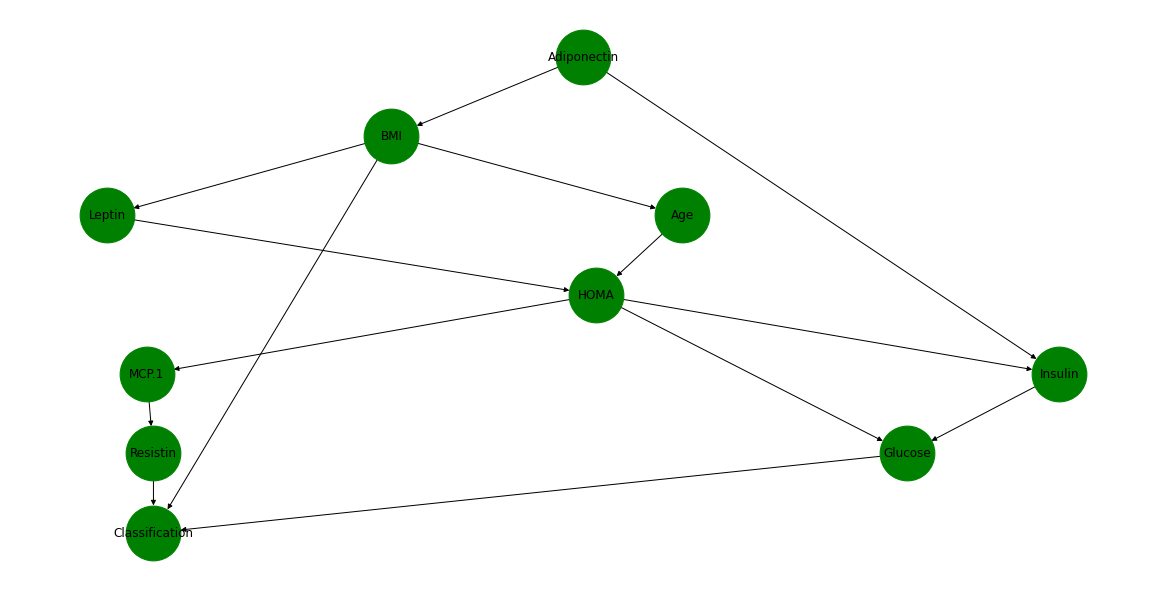

In [1706]:
pos = graphviz_layout(model, prog="dot")
plt.figure(figsize=(16, 8))
nx.draw(model, with_labels=True, pos=pos, node_size=3000, node_color="green")
# plt.savefig('model.png')
plt.show()


### Learning the parameters of the network

As mentioned before, pgmpy currently supports parameter learning only for networks with discrete nodes. There are 2 available methods for determining the values of the conditional probability distributions:
- Maximum Likelihood estimation.
        This method uses relative frequencies for estimating conditional probabilities. However, in case of small datasets it is prone to overfitting.
- Beyesian estimation.
       On the other hand, Bayesian estimator assumes prior CPDs on variables and then updates them using state counts from observed data.

In [1707]:
#Learning the parameters of the network
mle = MaximumLikelihoodEstimator(model, data)
print(mle.estimate_cpd('Age'))  # conditional
print(mle.estimate_cpd('BMI'))  # conditional
print(mle.estimate_cpd('Insulin'))  # unconditional


+------------+--------------------+----------+--------------------+
| BMI        | BMI(high)          | BMI(low) | BMI(medium)        |
+------------+--------------------+----------+--------------------+
| Age(24-54) | 0.5882352941176471 | 0.65     | 0.3728813559322034 |
+------------+--------------------+----------+--------------------+
| Age(55-79) | 0.4117647058823529 | 0.25     | 0.5254237288135594 |
+------------+--------------------+----------+--------------------+
| Age(80+)   | 0.0                | 0.1      | 0.1016949152542373 |
+------------+--------------------+----------+--------------------+
+-------------+--------------------+-----+----------------------+
| Adiponectin | Adiponectin(high)  | ... | Adiponectin(medium)  |
+-------------+--------------------+-----+----------------------+
| BMI(high)   | 0.0                | ... | 0.058823529411764705 |
+-------------+--------------------+-----+----------------------+
| BMI(low)    | 0.6666666666666666 | ... | 0.7058823529411

In [1708]:
#Fitting the model and checking if it has errors
model.fit(data, estimator=MaximumLikelihoodEstimator)
model.check_model()

True

In [1709]:
# checking the markov blanket for Classification  and Glucose
print("Markov blanket for variable:")
print("\nStroke: ", model.get_markov_blanket("Classification"))
print("\nHeart_disease: ", model.get_markov_blanket("Glucose"))

Markov blanket for variable:

Stroke:  ['BMI', 'Resistin', 'Glucose']

Heart_disease:  ['Insulin', 'BMI', 'HOMA', 'Resistin', 'Classification']
